<a href="https://colab.research.google.com/github/Karene123/Time-Series/blob/main/eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATA CLEANING AND DATA PROCESSING

In [1]:
#!git clone https://github.com/Karene123/Time-Series.git

Cloning into 'Time-Series'...
remote: Enumerating objects: 221, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 221 (delta 39), reused 5 (delta 5), pack-reused 159 (from 1)
Receiving objects: 100% (221/221), 4.80 MiB | 18.41 MiB/s, done.
Resolving deltas: 100% (86/86), done.


# Data Collection

In [2]:
!pip install sktime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.5/149.5 kB 10.7 MB/s eta 0:00:00


In [3]:
# === System Utilities ===
import os

# === Core Libraries ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# === Forecasting Utilities (sktime) ===
import sktime
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import make_reduction, TransformedTargetForecaster
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.detrend import Detrender, Deseasonalizer
from sktime.forecasting.all import (
    Deseasonalizer, Detrender, temporal_train_test_split,
    mean_absolute_percentage_error as mape,
    mean_squared_percentage_error as mspe,
    mean_squared_error as mse,
    ForecastingHorizon,
    NaiveForecaster,
    TransformedTargetForecaster,
    PolynomialTrendForecaster
)
from sktime.performance_metrics.forecasting import (
    MeanAbsolutePercentageError, MeanSquaredError, MeanAbsoluteScaledError
)

# === Statistical Modeling (statsmodels) ===
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
from statsmodels.tsa.api import VAR
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.stats.api import (
    het_breuschpagan, het_goldfeldquandt, het_white,
    jarque_bera, omni_normtest, normal_ad
)
from statsmodels.stats.diagnostic import (
    kstest_normal, acorr_ljungbox
)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.formula.api import ols
from statsmodels.tools.tools import add_constant
from statsmodels.graphics.gofplots import qqplot

# === Statistical Tests (scipy) ===
from scipy.stats import shapiro, kstest, normaltest, boxcox

In [4]:
filenames = ['CPIAUCSL(1).xlsx', 'FEDFUNDS(1).xlsx', 'GDPC1(1).xlsx', 'M2SL(1).xlsx', 'M2V(1).xlsx', 'DCOILBRENTEU(1).xlsx']

In [5]:
# create a for loop to collect the data
data_path = 'Time-Series/data/raw/'
dic = {}
for file in filenames:
  file_path = os.path.join(data_path, file)
  df = pd.read_excel(file_path)
  dic[file] = df

In [6]:
# Response variable
CPI_df = dic['CPIAUCSL(1).xlsx']
# Predictor variable
FEDFUNDS_df = dic['FEDFUNDS(1).xlsx']
GDP_df = dic['GDPC1(1).xlsx']
M2SL_df = dic['M2SL(1).xlsx']
M2V_df = dic['M2V(1).xlsx']

In [7]:
# Response Variable
#CPI_df = pd.read_excel('Time-Series/data/raw/CPIAUCSL(1).xlsx') #CPI for all urban customers

In [8]:
# Predictor variables
#FEDFUNDS_df = pd.read_excel('Time-Series/data/raw/FEDFUNDS(1).xlsx')
#GDP_df = pd.read_excel('Time-Series/data/raw/GDPC1(1).xlsx')
#M2SL_df = pd.read_excel('Time-Series/data/raw/M2SL(1).xlsx')
#M2V_df = pd.read_excel('Time-Series/data/raw/M2V(1).xlsx')
#DCOILBRENT_df = pd.read_excel('Time-Series/data/raw/DCOILBRENTEU(1).xlsx')

In [9]:
# Print all the dataframes
files = [CPI_df, FEDFUNDS_df, GDP_df, M2SL_df, M2V_df]
filenames = ['CPI_df', 'FEDFUNDS_df', 'GDP_df', 'M2SL_df', 'M2V_df']

for i in range(5):
  print(filenames[i])
  print(files[i])


CPI_df
    observation_date  CPIAUCSL
0         1947-01-01    21.480
1         1947-02-01    21.620
2         1947-03-01    22.000
3         1947-04-01    22.000
4         1947-05-01    21.950
..               ...       ...
932       2024-09-01   314.851
933       2024-10-01   315.564
934       2024-11-01   316.449
935       2024-12-01   317.603
936       2025-01-01   319.086

[937 rows x 2 columns]
FEDFUNDS_df
    observation_date  FEDFUNDS
0         1954-07-01      0.80
1         1954-08-01      1.22
2         1954-09-01      1.07
3         1954-10-01      0.85
4         1954-11-01      0.83
..               ...       ...
842       2024-09-01      5.13
843       2024-10-01      4.83
844       2024-11-01      4.64
845       2024-12-01      4.48
846       2025-01-01      4.33

[847 rows x 2 columns]
GDP_df
    observation_date      GDPC1
0         1947-01-01   2182.681
1         1947-04-01   2176.892
2         1947-07-01   2172.432
3         1947-10-01   2206.452
4         1948-01-01  

# Missing Data

In [10]:
for filename, file in zip(filenames, files):
    print(f"\n=== {filename} ===")
    print("Missing values Table:")
    print(file.isnull().sum())


=== CPI_df ===
Missing values Table:
observation_date    0
CPIAUCSL            0
dtype: int64

=== FEDFUNDS_df ===
Missing values Table:
observation_date    0
FEDFUNDS            0
dtype: int64

=== GDP_df ===
Missing values Table:
observation_date    0
GDPC1               0
dtype: int64

=== M2SL_df ===
Missing values Table:
observation_date    0
M2SL                0
dtype: int64

=== M2V_df ===
Missing values Table:
observation_date    0
M2V                 0
dtype: int64


# Merge

In [11]:
# Merge all the columns
data = pd.merge(pd.merge(pd.merge(pd.merge(CPI_df, FEDFUNDS_df, on='observation_date', how='outer'), M2SL_df, on='observation_date', how='outer'), M2V_df, on='observation_date', how='outer') , GDP_df, on='observation_date', how='outer')
data

,observation_date,CPIAUCSL,FEDFUNDS,M2SL,M2V,GDPC1
0,1947-01-01,21.480,NaN,NaN,NaN,2182.681
1,1947-02-01,21.620,NaN,NaN,NaN,NaN
2,1947-03-01,22.000,NaN,NaN,NaN,NaN
3,1947-04-01,22.000,NaN,NaN,NaN,2176.892
4,1947-05-01,21.950,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
932,2024-09-01,314.851,5.13,21252.4,NaN,NaN
933,2024-10-01,315.564,4.83,21332.7,1.386,23536.293
934,2024-11-01,316.449,4.64,21465.8,NaN,NaN
935,2024-12-01,317.603,4.48,21549.3,NaN,NaN


In [12]:
# Data Types
data.dtypes

,0
observation_date,datetime64[ns]
CPIAUCSL,float64
FEDFUNDS,float64
M2SL,float64
M2V,float64
GDPC1,float64


In [13]:
# Convert the month column to an index
data.index = data['observation_date']
del data['observation_date']

print(data.head())

                  CPIAUCSL  FEDFUNDS  M2SL  M2V     GDPC1
observation_date                                         
1947-01-01           21.48       NaN   NaN  NaN  2182.681
1947-02-01           21.62       NaN   NaN  NaN       NaN
1947-03-01           22.00       NaN   NaN  NaN       NaN
1947-04-01           22.00       NaN   NaN  NaN  2176.892
1947-05-01           21.95       NaN   NaN  NaN       NaN


In [14]:
data.index

DatetimeIndex(['1947-01-01', '1947-02-01', '1947-03-01', '1947-04-01',
               '1947-05-01', '1947-06-01', '1947-07-01', '1947-08-01',
               '1947-09-01', '1947-10-01',
               ...
               '2024-04-01', '2024-05-01', '2024-06-01', '2024-07-01',
               '2024-08-01', '2024-09-01', '2024-10-01', '2024-11-01',
               '2024-12-01', '2025-01-01'],
              dtype='datetime64[ns]', name='observation_date', length=937, freq=None)

In [15]:
data.index.freq = 'MS'
data.index

DatetimeIndex(['1947-01-01', '1947-02-01', '1947-03-01', '1947-04-01',
               '1947-05-01', '1947-06-01', '1947-07-01', '1947-08-01',
               '1947-09-01', '1947-10-01',
               ...
               '2024-04-01', '2024-05-01', '2024-06-01', '2024-07-01',
               '2024-08-01', '2024-09-01', '2024-10-01', '2024-11-01',
               '2024-12-01', '2025-01-01'],
              dtype='datetime64[ns]', name='observation_date', length=937, freq='MS')

Text(0.5, 1.0, 'GDPC1')

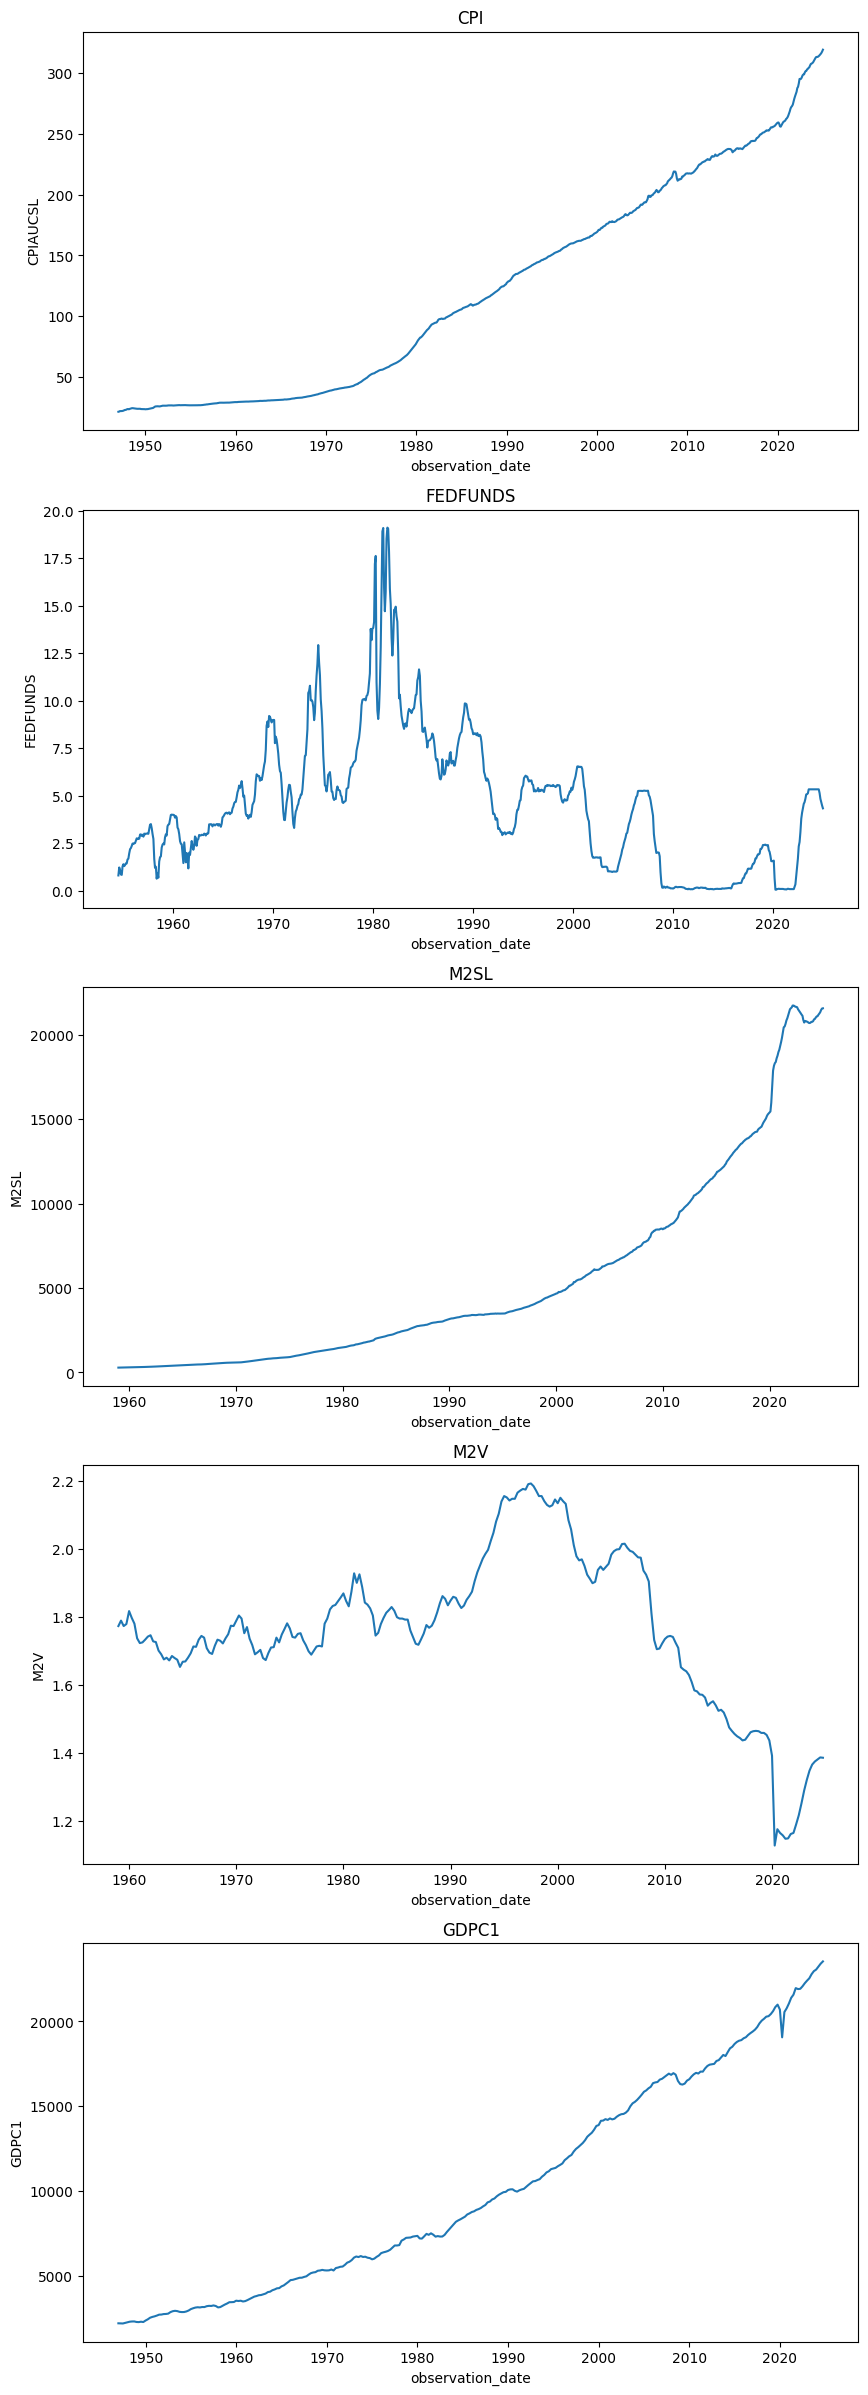

In [16]:
# Plot the data to observe the years where it starts to have missing data
plt.figure(figsize=(10, 30))

plt.subplot(5, 1, 1)
sns.lineplot(data['CPIAUCSL'])
plt.title("CPI")

plt.subplot(5, 1, 2)
sns.lineplot(data['FEDFUNDS'])
plt.title("FEDFUNDS")

plt.subplot(5, 1, 3)
sns.lineplot(data['M2SL'])
plt.title("M2SL")

plt.subplot(5, 1, 4)
sns.lineplot(data['M2V'])
plt.title("M2V")

plt.subplot(5, 1, 5)
sns.lineplot(data['GDPC1'])
plt.title("GDPC1")


In [17]:
# Slicing the data to include only the years of interest
data_sliced = data.loc["19600101":"20241001", :]
print(data_sliced)

                  CPIAUCSL  FEDFUNDS     M2SL    M2V      GDPC1
observation_date                                               
1960-01-01          29.370      3.99    298.2  1.817   3517.181
1960-02-01          29.410      3.97    298.4    NaN        NaN
1960-03-01          29.410      3.84    299.3    NaN        NaN
1960-04-01          29.540      3.92    300.1  1.797   3498.246
1960-05-01          29.570      3.85    300.9    NaN        NaN
...                    ...       ...      ...    ...        ...
2024-06-01         313.131      5.33  21079.2    NaN        NaN
2024-07-01         313.566      5.33  21093.6  1.387  23400.294
2024-08-01         314.131      5.33  21182.5    NaN        NaN
2024-09-01         314.851      5.13  21252.4    NaN        NaN
2024-10-01         315.564      4.83  21332.7  1.386  23536.293

[778 rows x 5 columns]


In [18]:
# Let's check again the number of missing values per column
data_sliced.isnull().sum()

,0
CPIAUCSL,0
FEDFUNDS,0
M2SL,0
M2V,518
GDPC1,518


In [19]:
# describe() shows a quick statistic summary of your data
data_sliced.describe()

,CPIAUCSL,FEDFUNDS,M2SL,M2V,GDPC1
count,778.000000,778.000000,778.000000,260.000000,260.000000
mean,140.131022,4.799987,5468.928406,1.762988,11616.687962
std,82.810720,3.648065,5728.520281,0.231132,5772.246084
min,29.370000,0.050000,298.200000,1.128000,3470.278000
25%,56.025000,1.935000,1052.700000,1.683750,6358.431000
50%,139.900000,4.760000,3399.250000,1.752000,10398.551000
75%,212.943750,6.527500,7802.450000,1.904250,16637.096000
max,315.564000,19.100000,21724.300000,2.192000,23536.293000


# Linear Interpolation


In [20]:
# Resample the columns
cols = ['M2V', 'GDPC1']
# Resample each column separately (interpolation)
for col in cols:
    data_sliced[col] = data_sliced[col].interpolate()

/tmp/ipython-input-1662887776.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sliced[col] = data_sliced[col].interpolate()


In [21]:
print(data_sliced)

                  CPIAUCSL  FEDFUNDS     M2SL       M2V         GDPC1
observation_date                                                     
1960-01-01          29.370      3.99    298.2  1.817000   3517.181000
1960-02-01          29.410      3.97    298.4  1.810333   3510.869333
1960-03-01          29.410      3.84    299.3  1.803667   3504.557667
1960-04-01          29.540      3.92    300.1  1.797000   3498.246000
1960-05-01          29.570      3.85    300.9  1.791333   3503.959000
...                    ...       ...      ...       ...           ...
2024-06-01         313.131      5.33  21079.2  1.385000  23341.498000
2024-07-01         313.566      5.33  21093.6  1.387000  23400.294000
2024-08-01         314.131      5.33  21182.5  1.386667  23445.627000
2024-09-01         314.851      5.13  21252.4  1.386333  23490.960000
2024-10-01         315.564      4.83  21332.7  1.386000  23536.293000

[778 rows x 5 columns]


In [22]:
data_sliced.describe()

,CPIAUCSL,FEDFUNDS,M2SL,M2V,GDPC1
count,778.000000,778.000000,778.000000,778.000000,778.000000
mean,140.131022,4.799987,5468.928406,1.763404,11611.777810
std,82.810720,3.648065,5728.520281,0.230508,5748.626019
min,29.370000,0.050000,298.200000,1.128000,3470.278000
25%,56.025000,1.935000,1052.700000,1.684500,6358.431000
50%,139.900000,4.760000,3399.250000,1.755500,10398.551000
75%,212.943750,6.527500,7802.450000,1.909083,16643.222000
max,315.564000,19.100000,21724.300000,2.192000,23536.293000


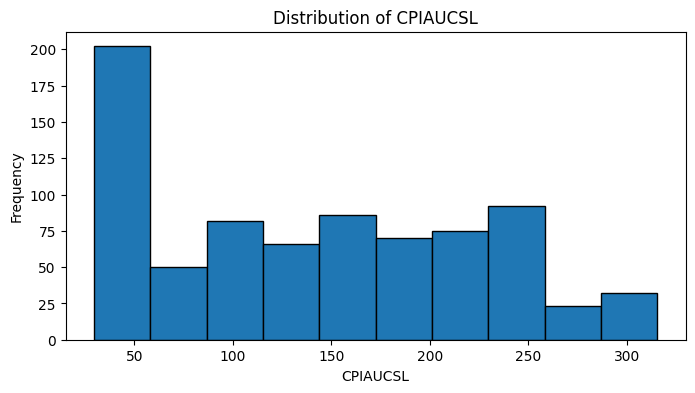

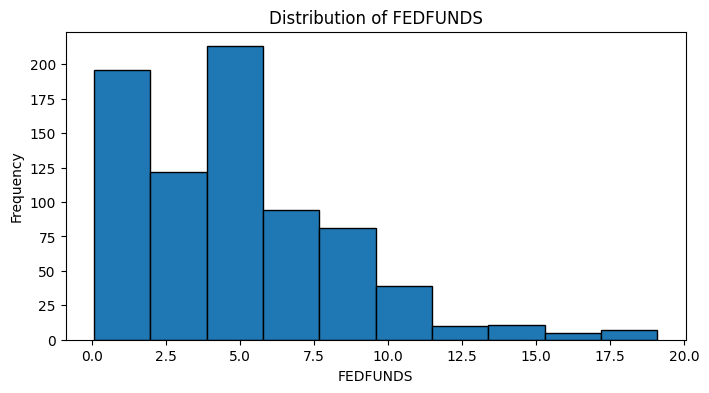

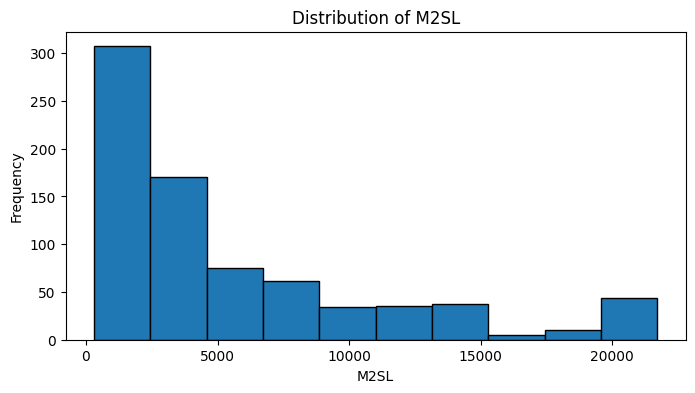

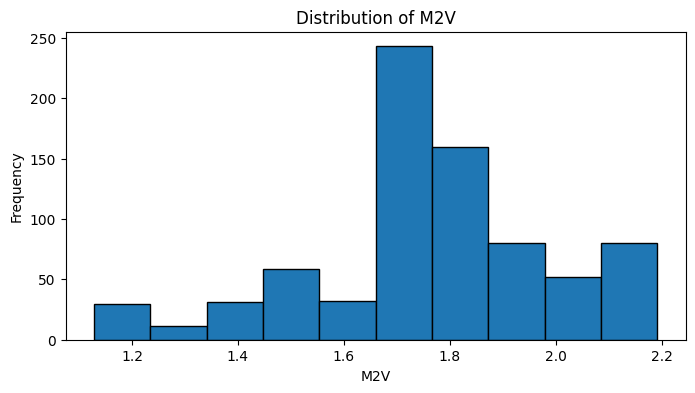

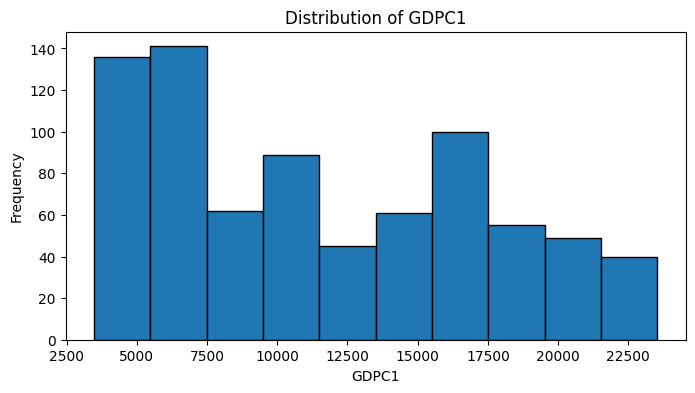

In [23]:
# Create a for loop to show all the distributions
for col in data_sliced.columns:
    # Check data type
    if data_sliced[col].dtype in ['int64', 'float64']:
        plt.figure(figsize=(8, 4))
        plt.hist(data_sliced[col], edgecolor='black')
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()

# Data Diagnosis

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning:

spsolve requires A be CSC or CSR matrix format



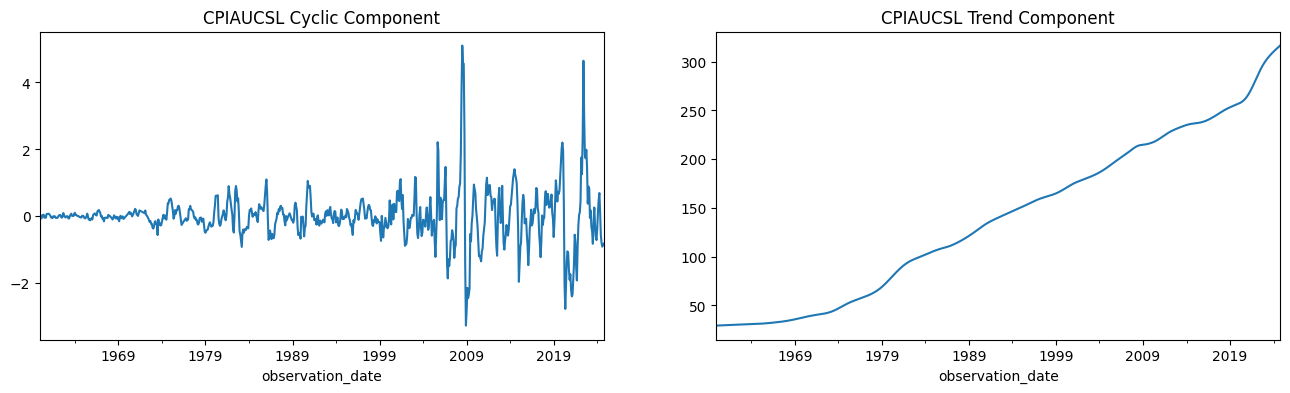

In [29]:
CPIAUCSL_cyclic, CPIAUCSL_trend = hpfilter(data_sliced['CPIAUCSL'])

fig, ax = plt.subplots(1,2, figsize=(16, 4))
CPIAUCSL_cyclic.plot(ax=ax[0], title='CPIAUCSL Cyclic Component')
CPIAUCSL_trend.plot(ax=ax[1], title='CPIAUCSL Trend Component')
plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning:

spsolve requires A be CSC or CSR matrix format



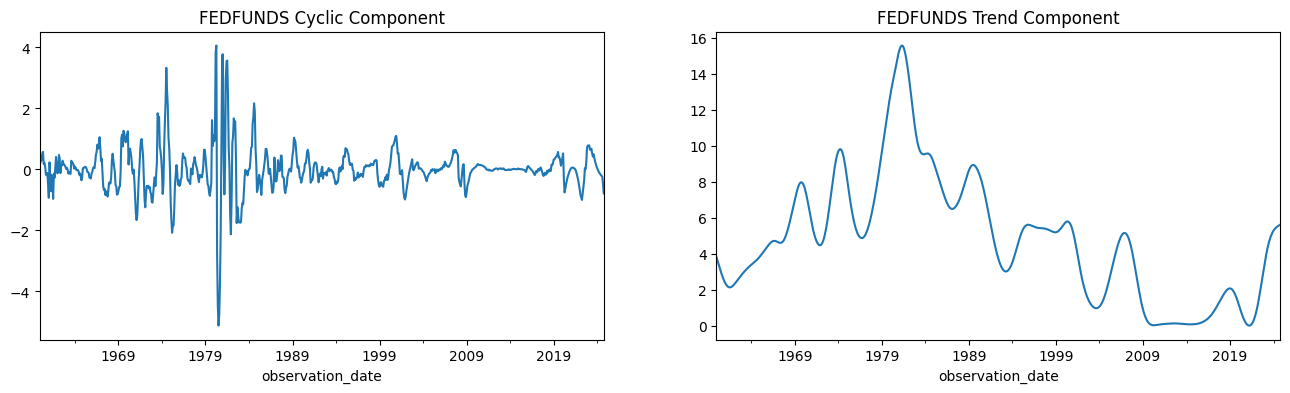

In [30]:
FEDFUNDS_cyclic, FEDFUNDS_trend = hpfilter(data_sliced['FEDFUNDS'])

fig, ax = plt.subplots(1,2, figsize=(16, 4))
FEDFUNDS_cyclic.plot(ax=ax[0], title='FEDFUNDS Cyclic Component')
FEDFUNDS_trend.plot(ax=ax[1], title='FEDFUNDS Trend Component')
plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning:

spsolve requires A be CSC or CSR matrix format



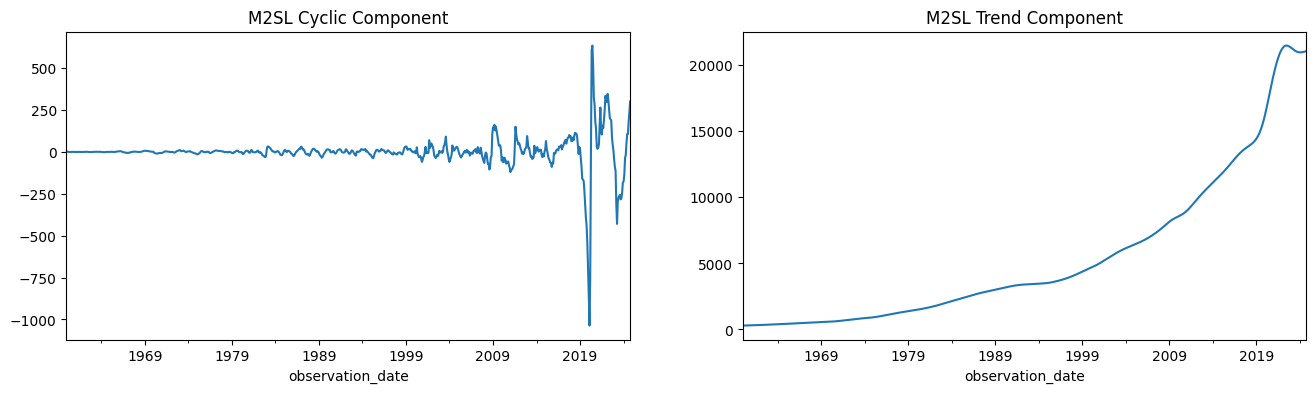

In [31]:
M2SL_cyclic, M2SL_trend = hpfilter(data_sliced['M2SL'])

fig, ax = plt.subplots(1,2, figsize=(16, 4))
M2SL_cyclic.plot(ax=ax[0], title='M2SL Cyclic Component')
M2SL_trend.plot(ax=ax[1], title='M2SL Trend Component')
plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning:

spsolve requires A be CSC or CSR matrix format



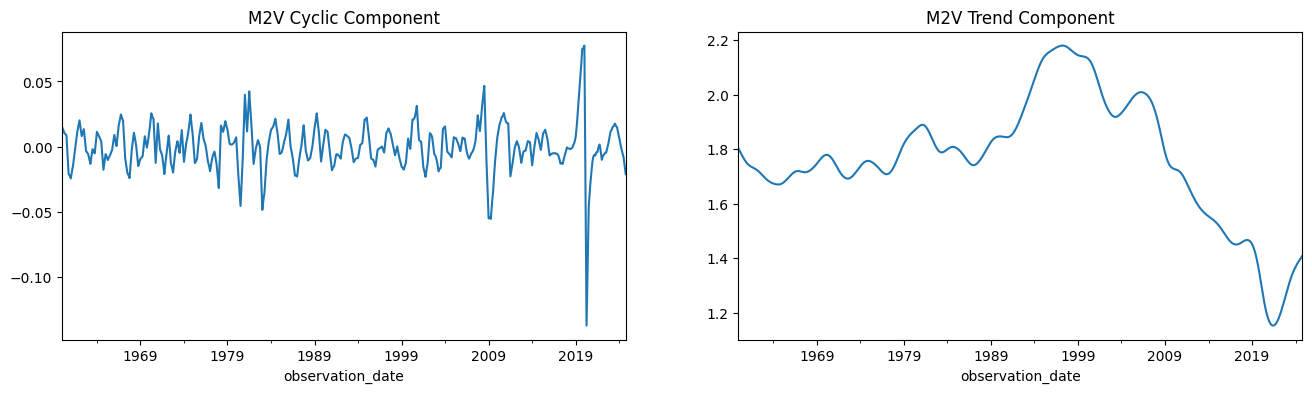

In [32]:
M2V_cyclic, M2V_trend = hpfilter(data_sliced['M2V'])

fig, ax = plt.subplots(1,2, figsize=(16, 4))
M2V_cyclic.plot(ax=ax[0], title='M2V Cyclic Component')
M2V_trend.plot(ax=ax[1], title='M2V Trend Component')
plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning:

spsolve requires A be CSC or CSR matrix format



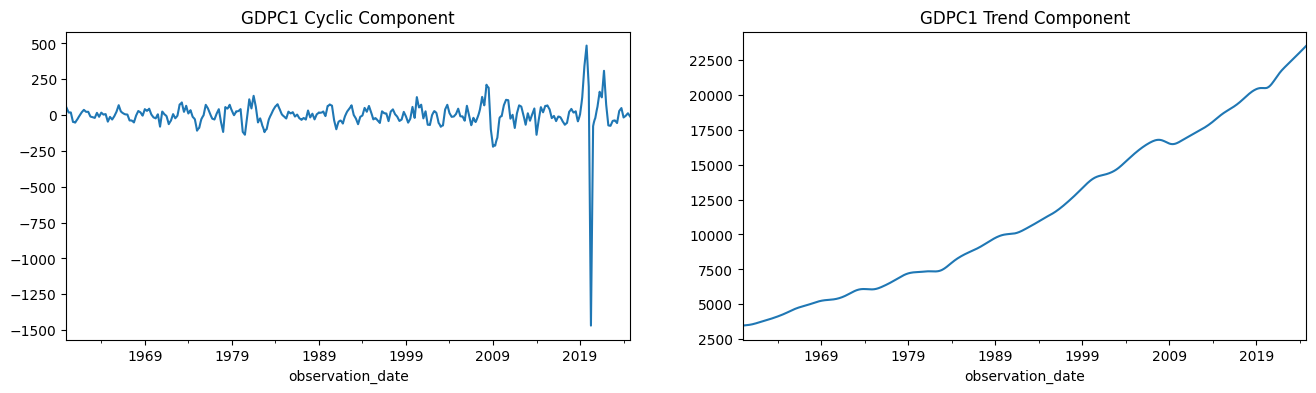

In [33]:
GDP_cyclic, GDP_trend = hpfilter(data_sliced['GDPC1'])

fig, ax = plt.subplots(1,2, figsize=(16, 4))
GDP_cyclic.plot(ax=ax[0], title='GDPC1 Cyclic Component')
GDP_trend.plot(ax=ax[1], title='GDPC1 Trend Component')
plt.show()

In [34]:
# Splitting the data between training and testing
data_train = data_sliced.loc[:'2020']
data_test = data_sliced.loc['2021':]
data_train.index

DatetimeIndex(['1960-01-01', '1960-02-01', '1960-03-01', '1960-04-01',
               '1960-05-01', '1960-06-01', '1960-07-01', '1960-08-01',
               '1960-09-01', '1960-10-01',
               ...
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01'],
              dtype='datetime64[ns]', name='observation_date', length=732, freq='MS')

In [35]:
# save the dataset
#data_test.to_csv('Time-Series/data/processed/final_data_processed_test.csv', index=True)

In [36]:
#data_train.to_csv('Time-Series/data/processed/final_data_processed_train.csv', index=True)